In [2]:
import pandas as pd
import seaborn as sb

In [27]:
dat_orders = pd.read_csv("dataset/olist_orders_dataset.csv")
dat_order_items = pd.read_csv("dataset/olist_order_items_dataset.csv")
dat_products = pd.read_csv("dataset/olist_products_dataset.csv")
dat_sellers = pd.read_csv("dataset/olist_sellers_dataset.csv")

In [34]:
join_items = dat_orders.set_index("order_id").join(dat_order_items.set_index("order_id"), lsuffix="ord", rsuffix="itm", validate="many_to_many", how="left")
join_products = join_items.set_index("product_id").join(dat_products.set_index("product_id"), lsuffix="itm", rsuffix="prd", validate="many_to_many", how="left")
join_sellers = join_products.set_index("seller_id").join(dat_sellers.set_index("seller_id"), lsuffix="itm", rsuffix="prd", validate="many_to_many", how="left")

join_sellers.groupby('seller_state').head()

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
seller_id,,,,,,,,,,,,,,,,,,,,,
3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,29.99,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
289cdb325fb7e7f891c38608bf9e0962,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,2018-07-30 03:24:27,118.70,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP
4869f7a5dfa277a7dca6462dcf3b52b2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,2018-08-13 08:55:23,159.90,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP
66922902710d126a0e7d26b0e3805106,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,2017-11-23 19:45:59,45.00,...,59.0,468.0,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG
2c9e548be18521d1c43cde1c582c6de8,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,2018-02-19 20:31:37,19.90,...,38.0,316.0,4.0,250.0,51.0,15.0,15.0,8752.0,mogi das cruzes,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c53bcd3be457a342a97e39e5a9f0be22,91e93abb370cd3dc6af2a46b988c593f,delivered,2017-05-31 11:55:59,2017-05-31 13:07:27,2017-06-02 05:19:45,2017-06-08 14:33:14,2017-07-03 00:00:00,1.0,2017-06-06 12:32:46,89.90,...,54.0,381.0,2.0,1400.0,38.0,9.0,27.0,49980.0,neopolis,SE
47efca563408aae19bb7206c2d969ea9,991a3891199a240b585e2d194403b768,delivered,2018-08-23 20:49:24,2018-08-23 21:04:35,2018-08-24 12:44:00,2018-08-29 17:04:08,2018-09-12 00:00:00,1.0,2018-08-29 21:04:35,285.00,...,34.0,92.0,1.0,2238.0,40.0,15.0,14.0,64033.0,teresina,PI
67225bff54a172ff67579aaf583efd78,c64ad317815a22929a63ffeaf92dfc1e,delivered,2017-09-15 10:34:54,2017-09-15 10:50:18,2017-09-15 19:03:38,2017-09-18 21:33:42,2017-10-03 00:00:00,1.0,2017-09-21 10:50:18,99.00,...,60.0,846.0,1.0,10825.0,60.0,25.0,34.0,85960.0,marechal candido rondon,PA


In [35]:
join_sellers.drop(columns=["seller_zip_code_prefix", "product_photos_qty", "product_name_lenght", "product_description_lenght"], inplace=True)

<Axes: ylabel='seller_id'>

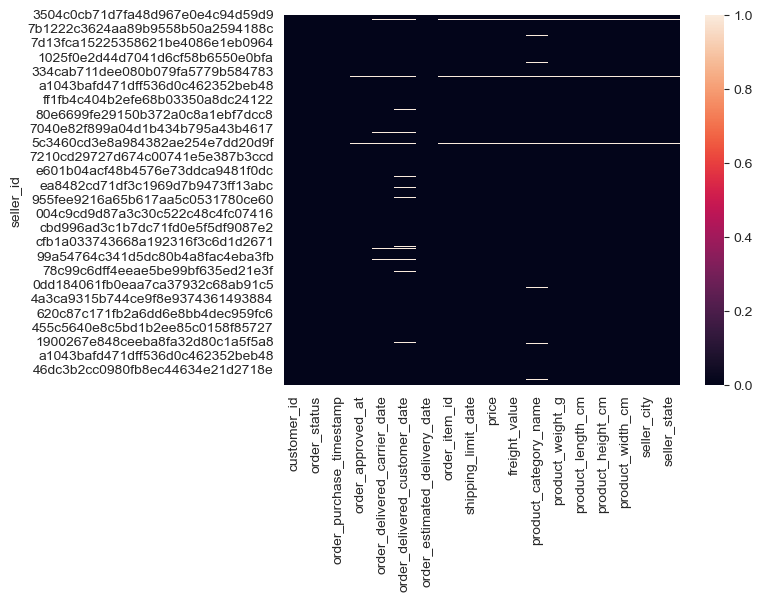

In [37]:
sb.heatmap(join_sellers.isna())

<Axes: >

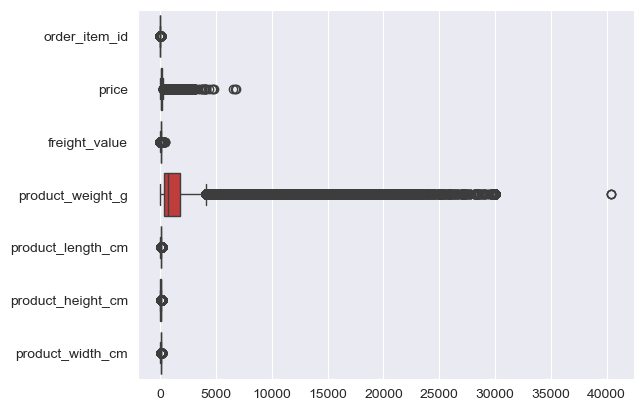

In [38]:
sb.boxplot(join_sellers, orient='h')